In [21]:
import tensorflow as tf

In [28]:
def U(t,T):
    U = tf.neural_net(tf.concat([t,T],1), weights, biases)
    return U

In [29]:
def f(t,T):
    u = U(t,T)
    u_t = tf.gradients(u, t)[0]
    u_tT = tf.gradients(u_t, T)[0]
    f = u_t + u_tT + ((2.303*tf.math.square(u)*tf.math.log(0.049/u))/t) - (14300*(tf.math.exp(-10656/T))*(10656*tf.math.log(T)))
    return f

In [9]:
!pip install torch

In [10]:
! pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=3c156265c5c0974d59ba79c650b33148a776bbacc5d2f05c10b4532b6020c04a
  Stored in directory: c:\users\bless\appdata\local\pip\cache\wheels\3c\ca\0d\63b767ad585fbcb3ea222541572dcb78859d0383510672b105
Successfully built pyDOE


In [11]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [12]:
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

In [179]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [182]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [32]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t])
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f = f_t + f_x_t + ((2.303*torch.square(f)*torch.log(0.049/f))/t) - (14300*(torch.exp(-10656/x))*(10656*torch.log(x)))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss

In [33]:
import deepxde as dde

ModuleNotFoundError: No module named 'deepxde'

In [34]:
!pip install deepxde

In [264]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [265]:
#the temperature is geom and it is represented in the interval 200-400C which is given by -1-1
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [266]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        2*dy_t
        + (14354*tf.exp(-10656/x[:, 1:]))
        * y + ((2.303/x[:, 0:1]) * tf.square(y))
    )

In [267]:
def func(x):
    return 49
def func2(x):
    return (-1+x[:, 0:1])*(-24.5+ x[:, 1:]*(1+x[:, 0:1]))


bc = dde.icbc.DirichletBC(geomtime, func2, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    num_test=100,
)
data.test()


[array([[ 1.        ,  0.5625    ],
        [ 1.        ,  0.84375   ],
        [-1.        ,  0.3125    ],
        [-1.        ,  0.625     ],
        [ 1.        ,  0.8125    ],
        [ 1.        ,  0.875     ],
        [-1.        ,  0.0625    ],
        [-1.        ,  0.375     ],
        [-1.        ,  0.9375    ],
        [ 1.        ,  0.6875    ],
        [ 1.        ,  0.4375    ],
        [ 1.        ,  0.46875   ],
        [ 1.        ,  0.96875   ],
        [-1.        ,  0.09375   ],
        [-1.        ,  0.34375   ],
        [ 1.        ,  0.125     ],
        [ 1.        ,  0.25      ],
        [ 1.        ,  0.75      ],
        [-1.        ,  0.59375   ],
        [-1.        ,  0.1875    ],
        [ 0.5       ,  0.        ],
        [-0.5       ,  0.        ],
        [-0.25      ,  0.        ],
        [ 0.75      ,  0.        ],
        [ 0.25      ,  0.        ],
        [-0.75      ,  0.        ],
        [-0.625     ,  0.        ],
        [ 0.375     ,  0.   

In [268]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...
'build' took 0.041186 s

'compile' took 0.764252 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.35e-02, 1.09e+03, 2.40e+03]    [inf, 1.09e+03, 2.40e+03]         []  
200       [3.66e+01, 1.00e+03, 2.30e+03]    [inf, 1.00e+03, 2.30e+03]         []  

Best model at step 200:
  train loss: 3.34e+03
  test loss: inf
  test metric: []

'train' took 2.182277 s

Saving loss history to C:\Users\bless\loss.dat ...
Saving training data to C:\Users\bless\train.dat ...
Saving test data to C:\Users\bless\test.dat ...


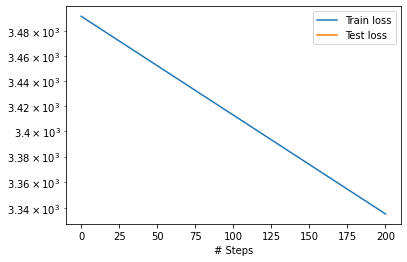

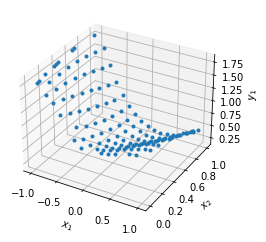

In [269]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=200)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [191]:
x_data = np.linspace(-1,1,num=10)
t_data = np.linspace(0,1,num=10)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator = pde)
ax = plt.axes(projection='3d')
ax.plot3D(test_domain,predicted_solution)

ValueError: input operand has more dimensions than allowed by the axis remapping

AttributeError: 'Line3D' object has no attribute '_verts3d'

<Figure size 432x288 with 1 Axes>

In [157]:
print(data)